# Project 2: Slot Filling

*By: Matthew Finlayson & Yuntian Deng*

*Based on the original version developed by Matthew Finlayson, Zilin Ma & Emma Rogge.*

In Slot filling (sequence labeling), the goal is to label the tokens in a sequence, such as when we want to determine the Part-of-Speech (POS) tag of every word in a sentence, or when we want to recognize the phonmes given a sequence of audio signal. In the last homework, you have built a classification system using Naive Bayes and logistic regression, but in sequence labeling, the token-level classification result not only depends on the observation at that position (captured by emission probability in HMM), but also depends on the context it appears in (modeled by transition probability in HMM).

In this homework, you will implement algorithms for slot filling. You will implement both an HMM based approach and a recurrent neural network (RNN) based approach. By the end of this homework, you should have grasped the pros and cons of both approaches.

## Goals

1. Implement an HMM approach to slot filling.
2. Implement an RNN-based approach to slot filling.
3. Implement an LSTM-based approach to slot filling.
4. Compare the performances of HMM and RNN under different sizes of training data. Discuss the pros and cons of the HMM approach and the neural approach.

## Setup

In [0]:
%%capture
import io
import os
import copy
import math
import random
import torch
import numpy as np 
import pandas as pd
import torch.nn as nn

from torchtext import datasets, data
from torchtext.data import Field

from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

#### Mount Data

The disk space of hosted runtime would get released after session ends. To avoid losing data, we can mount our Google Drive instead. 

In [0]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
import os
os.chdir('/content/gdrive/My Drive/Project2Slot')  #change dir

### Load Data

For this project, we will use the ATIS dataset (Airline Travel Information System) taken from Kaggle (https://www.kaggle.com/siddhadev/atis-dataset-from-ms-cntk). In this dataset, we are given questions regarding flight information, and the original task is to answer the questions using a database. However, here we use an intermediary task of POS tagging: given a question, associate each word with its POS. Note that here we use customized POS tags like "O" (uninteresting), "B-round_trip" (beginning of round trip), "I-round_trip" (continuing round trip), etc. Below is an example taken from Kaggle:



                              BOS                                        O
                         cheapest                          B-cost_relative
                          airfare                                        O
                             from                                        O
                           tacoma                      B-fromloc.city_name
                               to                                        O
                          orlando                        B-toloc.city_name
                              EOS                                        O


In this project, our goal is to find the POS tags "O B-cost_relative O O B-fromloc.city_name O B-toloc.city_name O" given the sentence "BOS cheapest airfair from tacoma to orlando EOS".

First, download the dataset.

In [0]:
!wget -q https://raw.githubusercontent.com/da03/HarvardCS280/master/atis.train.txt -O atis.train.txt
!wget -q https://raw.githubusercontent.com/da03/HarvardCS280/master/atis.dev.txt -O atis.dev.txt
!wget -q https://raw.githubusercontent.com/da03/HarvardCS280/master/atis.test.txt -O atis.test.txt

### Data Preprocessing

We use torchtext to load data and convert strings to indicies in the vocabulary.

In [0]:
MIN_FREQ = 3
WORD = data.Field(init_token="<bos>", eos_token="<eos>", batch_first=True)
TAG = data.Field(init_token="<bos>", eos_token="<eos>", batch_first=True)
fields=(('word', WORD), ('tag', TAG))

train, val, test = datasets.SequenceTaggingDataset.splits(
            fields=fields, path='./', train='atis.train.txt', validation='atis.dev.txt',
            test='atis.test.txt')

WORD.build_vocab(train.word, min_freq=MIN_FREQ)
TAG.build_vocab(train.tag)

print("Size of English vocab:", len(WORD.vocab))
print('Most comman English words:', WORD.vocab.freqs.most_common(10))

print("Size of POS vocab:", len(TAG.vocab))
print('Most comman POS tags:', TAG.vocab.freqs.most_common(10))

Size of English vocab: 519
Most comman English words: [('BOS', 4274), ('EOS', 4274), ('to', 3682), ('from', 3203), ('flights', 2075), ('the', 1745), ('on', 1343), ('flight', 1035), ('me', 1005), ('what', 985)]
Size of POS vocab: 105
Most comman POS tags: [('O', 38967), ('B-toloc.city_name', 3751), ('B-fromloc.city_name', 3726), ('I-toloc.city_name', 1039), ('B-depart_date.day_name', 835), ('I-fromloc.city_name', 636), ('B-airline_name', 610), ('B-depart_time.period_of_day', 555), ('I-airline_name', 374), ('B-depart_date.day_number', 351)]


Now, we can iterate over the dataset using torch's iterator.

In [0]:
BATCH_SIZE = 1 # for simplicity we use batch size 1
train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (train, val, test), batch_size=BATCH_SIZE, repeat=False)

batch = next(iter(val_iter))

print("the first batch of words:", batch.word)
print ("converted to words:", [WORD.vocab.itos[i] for i in batch.word[0].cpu().tolist()])
print("the first batch tags", batch.tag)
print ("converted to tags:", [TAG.vocab.itos[i] for i in batch.tag[0].cpu().tolist()])

the first batch of words: tensor([[  2,   4, 213,   5,   3]])
converted to words: ['<bos>', 'BOS', 'airports', 'EOS', '<eos>']
the first batch tags tensor([[2, 4, 4, 4, 3]])
converted to tags: ['<bos>', 'O', 'O', 'O', '<eos>']


## Goal 1: HMM for Slot Filling
With the iterator, we are ready to implement the HMM and RNN based algorithms for slot filling. First, let's use $Q$ to denote the set of possible POS tags. It is the state space of an HMM, although in our case all states are observed in the training data. Let's use $W$ to denote the vocabulary of all possible words.




### Learning HMM through counting

Recall that an HMM is defined via a transition matrix $A$ which states the probability of moving from one state $q_i$ to another $q_j$ via $a_{ij}=P(q^{t+1}=q_j | q^t=q_i)$, and an emission matrix $B$ which states the probability of generating word $w_i$ given state $q_j$ via $b_{ij}= P(w^t=w_i |q^t= q_j)$. In our case, since all slots are already observed, we can directly use counting to determine $A$ and $B$.

#### **Goal 1 (a): Find the transition matrix**
(Jurafsky 8.4.3)

The matrix $A$ contains the transition probabilities; $a_ij \in A$ is the probability of moving from state $q_i \in Q$ to state $q_j$ such that $\sum^{n-1}_{j = 0 } a_{ij} = 1$ for all $i$. 

We find these probabilities by counting the number of times state $q_j$ occurs directly after state $q_i$ divided by the number of times state $q_i$ occurs.

$$
a_{ij} = \frac{C(q_iq_j) + 0.01}{C(q_i) + 0.01|Q|}
$$

In the above formula, we also use LaPlace smoothing to account for the finite size of our training data.

Use the above definitions, find the transition matrix $A$.

#### **Solution 1 (a)**

In [0]:
# Initialize A
state_size = len(TAG.vocab)
A = torch.zeros(state_size, state_size).fill_(0.01)

# A[i][j] = the number of times state j follows state i
for batch in train_iter:
  assert batch.tag.size(0) == 1, 'this implementation only considers batch size 1'
  tags = batch.tag[0]
  tags = tags.cpu().tolist()
  for i, state in enumerate(tags):
      if i == len(tags) -  1:
          break
      else:
          A[state][tags[i + 1]] += 1

# Normalize A to get probabilities
A = A / A.sum(-1).unsqueeze(-1)

print(A)

tensor([[9.5238e-03, 9.5238e-03, 9.5238e-03,  ..., 9.5238e-03, 9.5238e-03,
         9.5238e-03],
        [9.5238e-03, 9.5238e-03, 9.5238e-03,  ..., 9.5238e-03, 9.5238e-03,
         9.5238e-03],
        [2.3392e-06, 2.3392e-06, 2.3392e-06,  ..., 2.3392e-06, 2.3392e-06,
         2.3392e-06],
        ...,
        [3.2787e-03, 3.2787e-03, 3.2787e-03,  ..., 3.3115e-01, 3.2787e-03,
         3.2787e-03],
        [4.8780e-03, 4.8780e-03, 4.8780e-03,  ..., 4.8780e-03, 4.8780e-03,
         4.8780e-03],
        [4.8780e-03, 4.8780e-03, 4.8780e-03,  ..., 4.8780e-03, 4.9268e-01,
         4.8780e-03]])


#### **Goal 1(b): Find the emission matrix $B$**
(Jurafsky 8.4.3)

Similar to the transition matrix, the emission matrix contains the emission probabilities such that $b_{ij} \in B$ is probability of the vocabulary word $w_j \in W$ occuring given that the state is $q_i \in Q$.

We can find this by counting as well.
$$
P(w_i|q_j) = \frac{C(w_i, q_j) + 0.01}{C(q_j) + 0.01|W|}
$$

Again we use LaPlace smoothing to account for the finite size of our training data.

#### **Solution 1 (b)**

In [0]:
# Initialize B
state_size, word_size = len(TAG.vocab), len(WORD.vocab)
B = torch.zeros(state_size, word_size).fill_(0.01)

# B[i][j] is the number of times state i produces word j
for batch in train_iter:
  assert batch.tag.size(0) == 1, 'this implementation only considers batch size 1'
  tags = batch.tag[0]
  tags = tags.cpu().tolist()
  words = batch.word[0]
  words = words.cpu().tolist()
  for state, word in zip(tags, words):
    B[state][word] += 1


# Normalize B to get probabilities
B = B / B.sum(-1).unsqueeze(-1)

print(B)

tensor([[1.9268e-03, 1.9268e-03, 1.9268e-03,  ..., 1.9268e-03, 1.9268e-03,
         1.9268e-03],
        [1.9268e-03, 1.9268e-03, 1.9268e-03,  ..., 1.9268e-03, 1.9268e-03,
         1.9268e-03],
        [2.3369e-06, 2.3369e-06, 9.9879e-01,  ..., 2.3369e-06, 2.3369e-06,
         2.3369e-06],
        ...,
        [1.3908e-03, 1.3908e-03, 1.3908e-03,  ..., 1.3908e-03, 1.3908e-03,
         1.3908e-03],
        [1.6155e-03, 1.6155e-03, 1.6155e-03,  ..., 1.6155e-03, 1.6155e-03,
         1.6155e-03],
        [1.6155e-03, 1.6155e-03, 1.6155e-03,  ..., 1.6155e-03, 1.6155e-03,
         1.6155e-03]])


### Slot Filling with a learned HMM
(Jurafsky 8.4.4)

Now that we've already trained an HMM by counting the transition matrix $A$ and the emission matrix $B$, we can apply it to the task of slot filling. Our objective is to find the most probable sequence of slots (parts-of-speech) $\hat q \in Q^n$ given a sequence of words $w \in V^n$.

$$
\hat q = \text{argmax}_{q \in Q^n}(P(q|w))= \text{argmax}_{q \in Q^n}(P(q,w))=\text{argmax}_{q \in Q^n}\left(\Pi^{n - 1}_{t = 0} P(w^t|q^t)P(q^{t+1}|q^t)\right)
$$
where $P(w^t=w_j|q^t=q_i) = b_{ij}$ can be retrieved from our emission matrix $B$, $P(q^{t+1}=q_j|q^t=q_{i})=a_{ij}$ can be retrieved from our transition matrix $A$.



##### **Goal 1 (c): Viterbi algorithm**

Use dynamic programming to find the most likely sequence for the sequences in the test set and calculate accuracy. Implement the interface viterbi(words, A, B) and compute accuracy using the below code.

In [0]:
# compute accuracy given tagging function f(words, A, B)
def compute_accuracy(f):
  correct = 0
  total = 0
  for batch in test_iter:
    words = batch.word[0].cpu().tolist()
    tags = batch.tag[0].cpu().tolist()
    tags_pred = f(words)
    for j, tag in enumerate(tags):
      if j == 0 or j == len(tags)-1:
        continue
      total += 1
      if j < len(tags_pred) and tags_pred[j] == tag:
        correct += 1
    print("Accuracy: {}".format(correct/total))

  #print("Accuracy: {}".format(correct/total))
  return correct/total

def viterbi(words):
  # TODO: replace baseline with your implementation here
  return [TAG.vocab.stoi['O'] for _ in words]

compute_accuracy(viterbi)

Accuracy: 0.6666666666666666
Accuracy: 0.6666666666666666
Accuracy: 0.6666666666666666
Accuracy: 0.6842105263157895
Accuracy: 0.68
Accuracy: 0.6666666666666666
Accuracy: 0.6623376623376623
Accuracy: 0.6526315789473685
Accuracy: 0.6403508771929824
Accuracy: 0.6573426573426573
Accuracy: 0.6573426573426573


0.6573426573426573

#### **Solution 1(c)**

In [0]:
def viterbi(words):
  words = words[1:-1]
  V = np.empty((len(words), len(TAG.vocab)))
  V = V.tolist()
  V[0] = [(0, None) for node in V[0]]
  V[0][TAG.vocab.stoi['O']] = (1, None)
  n = 0
  for prev_row, cur_row in zip(range(len(words)), range(1, len(words))):
    for cur_state in range(len(TAG.vocab)):
      max_prob = 0
      back_pointer = None
      for prev_state in range(len(TAG.vocab)):
        # TODO: use log space instead
        probability = V[prev_row][prev_state][0] * A[prev_state][cur_state] * B[cur_state][words[cur_row]]
        if probability > max_prob:
          max_prob = probability
          back_pointer = prev_state
      V[cur_row][cur_state] = (max_prob, back_pointer)
  
  def best_path(pointer, i):
    if not pointer:
      return []
    prev = V[i][pointer][1]
    return best_path(prev, i - 1) + [pointer]
  
  last_row = V[-1]
  most_likely = max(range(len(TAG.vocab)), key=lambda x: V[-1][x][0])
  return [0]+best_path(most_likely, -1)+[0]
compute_accuracy(viterbi)

## Goal 2: RNN for Slot Filling
HMMs work pretty well for this slot filling task. Now let's take an alternative (and more popular) approach: RNN (LSTM) based sequence tagging. Similar to the HMM part of this project, you will need to both learn a model using training data, and decode using a trained model.



![RNN Visualization](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Recurrent_neural_network_unfold.svg/2880px-Recurrent_neural_network_unfold.svg.png)
The recurrent neural network is simple, after unfolding it. Each subsequent cell takes the output of the previous cell using the following equations. This can be done in Pytorch by using modules such as torch.nn.linear.

$$
h_t = \sigma_h (W_h x_t + U_h h_{t-1} + b_h)
$$

$$
y_t = \sigma_y (W_y h_t + b_y)
$$

### Learning RNN through back-propagation

To learn an RNN for sequence tagging, we will compute loss based on training data, and then back-propagate to compute the gradients with respect to its parameters. Finally, we will update the parameters along the direction of the negative gradients to minimize the loss.

#### **Goal 2 (a): RNN training**

Implement the forward pass of the RNN tagger and the loss function using the below starter code. The training/optimization code is already provided.

In [0]:
###################
#       RNN       #
###################

class RNNTagger(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, 
                embedding_dim = 36, lr = 0.0003):
    super(RNNTagger, self).__init__()

    self.hidden_size = hidden_size
    # TODO: implement below
    raise NotImplementedError


  def forward(self, input, hidden):
    # TODO: implement below
    return output, hidden

  def compute_loss(output, ground_truth):
    # TODO: implement below
    return loss


  def train_epoch(self, train_iter, val_iter, epochs = 3, lr = 0.001):
    self.optimizer = optim.Adam(self.parameters(), lr=lr)
    self.train()
    best_ppl = float('inf')
    for epoch in range(epochs): 
      print("epoch:", epoch)
      for batch in train_iter:
        words = batch.word[0]
        tags = batch.tag[0]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        self.zero_grad()

        # Step 2. Run our forward pass.
        hidden = torch.zeros(1, self.hidden_size)
        loss = 0
        for word, tag in zip(words, tags):
          output, hidden = self.forward(word.view(-1), hidden)
          loss = loss + compute_loss(output, tag.view(-1))
        # Step 3. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss.backward()
        self.optimizer.step()
      val_ppl = self.validate(val_iter)
      print ('Epoch:', epoch, "PPL:", val_ppl)
      if val_ppl < best_ppl:
        best_ppl = val_ppl
        best_state_dict = copy.deepcopy(self.state_dict())
    # use the model with the best val ppl
    self.load_state_dict(best_state_dict)

  def validate(self, val_iter):
    self.eval()
    # we don't want to change the gradient while validating. 
    tot_loss = 0
    tot_count = 0
    with torch.no_grad():
      for batch in val_iter:
        words = batch.word[0]
        tags = batch.tag[0]

        # Step 1. Run our forward pass.
        hidden = torch.zeros(1, self.hidden_size)
        loss = 0
        for word, tag in zip(words, tags):
          output, hidden = self(word.view(-1), hidden)
          loss = loss + self.loss_function(output, tag.view(-1))
        tot_count += len(words)
        tot_loss += loss
      ppl = math.exp(tot_loss / tot_count)
      return ppl


rnn = RNNTagger(len(WORD.vocab), hidden_size = 36, output_size = len(TAG.vocab), embedding_dim = 36)
rnn.train_epoch(train_iter, val_iter)

#### **Solution 2 (a)**

In [0]:
###################
#       RNN       #
###################

class RNNTagger(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, 
                embedding_dim = 36, lr = 0.0003):
    super(RNNTagger, self).__init__()

    self.hidden_size = hidden_size
    self.word_embeddings = nn.Embedding(input_size, embedding_dim)
    self.i2h = nn.Linear(embedding_dim + hidden_size, hidden_size)
    self.i2o = nn.Linear(embedding_dim + hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=-1)
    self.loss_function = nn.NLLLoss(reduction='sum')


  def forward(self, input, hidden):
    embeds = self.word_embeddings(input)
    combined = torch.cat((embeds.view([1, -1]), hidden), 1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output, hidden

  def train_epoch(self, train_iter, val_iter, epochs = 3, lr = 0.001):
    #rnn = RNNTagger(len(word_to_indx), HIDDEN_DIM, len(slot_to_indx))
    self.optimizer = optim.Adam(self.parameters(), lr=lr)
    self.train()
    best_ppl = float('inf')
    for epoch in range(epochs): 
      print("epoch:", epoch)
      for batch in train_iter:
        words = batch.word[0]
        tags = batch.tag[0]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        self.zero_grad()

        # Step 2. Run our forward pass.
        hidden = torch.zeros(1, self.hidden_size)
        loss = 0
        for word, tag in zip(words, tags):
          output, hidden = self(word.view(-1), hidden)
          loss = loss + self.loss_function(output, tag.view(-1))
        # Step 3. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss.backward()
        self.optimizer.step()
      val_ppl = self.validate(val_iter)
      print ('Epoch:', epoch, "PPL:", val_ppl)
      if val_ppl < best_ppl:
        best_ppl = val_ppl
        best_state_dict = copy.deepcopy(self.state_dict())
    # use the model with the best val ppl
    self.load_state_dict(best_state_dict)

  def validate(self, val_iter):
    self.eval()
    # we don't want to change the gradient while validating. 
    tot_loss = 0
    tot_count = 0
    with torch.no_grad():
      for batch in val_iter:
        words = batch.word[0]
        tags = batch.tag[0]

        # Step 1. Run our forward pass.
        hidden = torch.zeros(1, self.hidden_size)
        loss = 0
        for word, tag in zip(words, tags):
          output, hidden = self.forward(word.view(-1), hidden)
          loss = loss + self.loss_function(output, tag.view(-1))
        tot_count += len(words)
        tot_loss += loss
      ppl = math.exp(tot_loss / tot_count)
      return ppl


rnn = RNNTagger(len(WORD.vocab), hidden_size = 36, output_size = len(TAG.vocab), embedding_dim = 36)
rnn.train_epoch(train_iter, val_iter)

epoch: 0


KeyboardInterrupt: ignored

#### **Goal 2 (b) RNN decoding**

With a trained RNN, implement rnnDecode to tag the test set.

In [0]:
def rnnDecode(words):
  # Step 2. Run our forward pass.
  hidden = torch.zeros(1, rnn.hidden_size)
  loss = 0
  tags = []
  for word in torch.LongTensor(words):
    # TODO: replace below with your implementation
    tags.append(TAG.vocab.stoi['O'])
  return tags
compute_accuracy(rnnDecode)


Accuracy: 0.6827210177852785


#### **Solution 2 (b)**

In [0]:
def rnnDecode(words):
  # Step 2. Run our forward pass.
  hidden = torch.zeros(1, rnn.hidden_size)
  loss = 0
  tags = []
  for word in torch.LongTensor(words):
    output, hidden = rnn.forward(word.view(-1), hidden)
    _, tag = torch.max(output.view(-1), 0)
    tags.append(tag.item())
  return tags
compute_accuracy(rnnDecode)

Accuracy: 0.9702713228612229


## Goal 3: LSTM for Slot Filliing
Did your RNN perform better at the task than HMM? How much better was it? Was it expected? RNN has a vanishing gradient problem. https://en.wikipedia.org/wiki/Vanishing_gradient_problem To solve this, Long-Short Term Memory was introduced. The full implementation is simplified to just calling LSTM() from pytorch. 

### LSTM training

#### **Goal 3 (a) Use LSTM instead of RNN**

Use LSTM instead of RNN to do slot filling, implement the LSTMTagger interface with the below starter code.

In [0]:
###################
#       LSTM      #
###################

class LSTMTagger(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, 
                embedding_dim = 36, lr = 0.0003):
    super(LSTMTagger, self).__init__()

    self.hidden_size = hidden_size
    # TODO: implement below
    raise NotImplementedError

  def forward(self, input, hidden):
    # TODO: implement below
    return output, hidden

  def compute_loss(self, output, ground_truth):
    # TODO: implement below
    return loss

  def train_epoch(self, train_iter, val_iter, epochs = 3, lr = 0.001):
    self.optimizer = optim.Adam(self.parameters(), lr=lr)
    self.train()
    best_ppl = float('inf')
    for epoch in range(epochs): 
      print("epoch:", epoch)
      for batch in train_iter:
        words = batch.word[0]
        tags = batch.tag[0]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        self.zero_grad()

        # Step 2. Run our forward pass.
        hidden = torch.zeros(1, 1, self.hidden_size)
        hidden = (hidden, hidden)
        loss = 0
        for word, tag in zip(words, tags):
          output, hidden = self(word.view(-1), hidden)
          loss = loss + compute_loss(output, tag.view(-1))
        # Step 3. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss.backward()
        self.optimizer.step()
      val_ppl = self.validate(val_iter)
      print ('Epoch:', epoch, "PPL:", val_ppl)
      if val_ppl < best_ppl:
        best_ppl = val_ppl
        best_state_dict = copy.deepcopy(self.state_dict())
    # use the model with the best val ppl
    self.load_state_dict(best_state_dict)

  def validate(self, val_iter):
    self.eval()
    # we don't want to change the gradient while validating. 
    tot_loss = 0
    tot_count = 0
    with torch.no_grad():
      for batch in val_iter:
        words = batch.word[0]
        tags = batch.tag[0]

        # Step 1. Run our forward pass.
        hidden = torch.zeros(1, 1, self.hidden_size)
        hidden = (hidden, hidden)
        loss = 0
        for word, tag in zip(words, tags):
          output, hidden = self.forward(word.view(-1), hidden)
          loss = loss + self.loss_function(output, tag.view(-1))
        tot_count += len(words)
        tot_loss += loss
      ppl = math.exp(tot_loss / tot_count)
      return ppl


lstm = LSTMTagger(len(WORD.vocab), hidden_size = 36, output_size = len(TAG.vocab), embedding_dim = 36)
lstm.train_epoch(train_iter, val_iter)

#### **Solution 3 (a)**

In [0]:
###################
#       LSTM      #
###################

class LSTMTagger(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, 
                embedding_dim = 36, lr = 0.0003):
    super(LSTMTagger, self).__init__()

    self.hidden_size = hidden_size
    self.word_embeddings = nn.Embedding(input_size, embedding_dim)
    # The LSTM takes word embeddings as inputs, and outputs hidden states
    # with dimensionality hidden_dim.
    self.lstm = nn.LSTM(embedding_dim, hidden_size)

    # The linear layer that maps from hidden state space to tag space
    self.i2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=-1)
    self.loss_function = nn.NLLLoss(reduction='sum')


  def forward(self, input, hidden):
    embeds = self.word_embeddings(input)
    output, hidden = self.lstm(embeds.view(1,1,-1), hidden)
    output = self.i2o(output.view(1, -1))
    output = self.softmax(output)
    return output, hidden

  def train_epoch(self, train_iter, val_iter, epochs = 3, lr = 0.001):
    #rnn = RNNTagger(len(word_to_indx), HIDDEN_DIM, len(slot_to_indx))
    self.optimizer = optim.Adam(self.parameters(), lr=lr)
    self.train()
    best_ppl = float('inf')
    for epoch in range(epochs): 
      print("epoch:", epoch)
      for batch in train_iter:
        words = batch.word[0]
        tags = batch.tag[0]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        self.zero_grad()

        # Step 2. Run our forward pass.
        hidden = torch.zeros(1, 1, self.hidden_size)
        hidden = (hidden, hidden)
        loss = 0
        for word, tag in zip(words, tags):
          output, hidden = self(word.view(-1), hidden)
          loss = loss + self.loss_function(output, tag.view(-1))
        # Step 3. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss.backward()
        self.optimizer.step()
      val_ppl = self.validate(val_iter)
      print ('Epoch:', epoch, "PPL:", val_ppl)
      if val_ppl < best_ppl:
        best_ppl = val_ppl
        best_state_dict = copy.deepcopy(self.state_dict())
    # use the model with the best val ppl
    self.load_state_dict(best_state_dict)

  def validate(self, val_iter):
    self.eval()
    # we don't want to change the gradient while validating. 
    tot_loss = 0
    tot_count = 0
    with torch.no_grad():
      for batch in val_iter:
        words = batch.word[0]
        tags = batch.tag[0]

        # Step 1. Run our forward pass.
        hidden = torch.zeros(1, 1, self.hidden_size)
        hidden = (hidden, hidden)
        loss = 0
        for word, tag in zip(words, tags):
          output, hidden = self.forward(word.view(-1), hidden)
          loss = loss + self.loss_function(output, tag.view(-1))
        tot_count += len(words)
        tot_loss += loss
      ppl = math.exp(tot_loss / tot_count)
      return ppl


lstm = LSTMTagger(len(WORD.vocab), hidden_size = 36, output_size = len(TAG.vocab), embedding_dim = 36)
lstm.train_epoch(train_iter, val_iter)

epoch: 0
Epoch: 0 PPL: 1.3187368676820297
epoch: 1
Epoch: 1 PPL: 1.1668826391099156
epoch: 2
Epoch: 2 PPL: 1.121405831453758


### LSTM Decoding


#### **Goal 3 (b) Use LSTM for decoding**

In [0]:
def lstmDecode(words):
  # Step 2. Run our forward pass.
  hidden = torch.zeros(1, 1, lstm.hidden_size)
  hidden = (hidden, hidden)
  loss = 0
  tags = []
  for word in torch.LongTensor(words):
    # TODO: replace below with your implementation
    tag = TAG.vocab.stoi['O']
    tags.append(tag.item())
  return tags
compute_accuracy(lstmDecode)


#### **Solution 3 (b)**

In [0]:
def lstmDecode(words):
  # Step 2. Run our forward pass.
  hidden = torch.zeros(1, 1, lstm.hidden_size)
  hidden = (hidden, hidden)
  loss = 0
  tags = []
  for word in torch.LongTensor(words):
    output, hidden = lstm.forward(word.view(-1), hidden)
    _, tag = torch.max(output.view(-1), 0)
    tags.append(tag.item())
  return tags
compute_accuracy(lstmDecode)


Accuracy: 0.9657276385823705


## **Goal 4: Compare HMM to RNN/LSTM under different amount of training data**

Vary the amount of training data, compare the performance of HMM to RNN/LSTM. Discuss what are the pros and cons of HMM and RNN/LSTM? 

The below code shows how to subsample the training set with downsample ratio `ratio`.

In [0]:
ratio = 0.1
MIN_FREQ = 3
WORD = data.Field(init_token="<bos>", eos_token="<eos>", batch_first=True)
TAG = data.Field(init_token="<bos>", eos_token="<eos>", batch_first=True)
fields=(('word', WORD), ('tag', TAG))

train, val, test = datasets.SequenceTaggingDataset.splits(
            fields=fields, path='./', train='atis.train.txt', validation='atis.dev.txt',
            test='atis.test.txt')

random.shuffle(train.examples)
train.examples = train.examples[:int(math.floor(len(train.examples)*ratio))]
WORD.build_vocab(train.word, min_freq=MIN_FREQ)
TAG.build_vocab(train.tag)

print("Size of English vocab:", len(WORD.vocab))
print('Most comman English words:', WORD.vocab.freqs.most_common(10))

print("Size of POS vocab:", len(TAG.vocab))
print('Most comman POS tags:', TAG.vocab.freqs.most_common(10))

Size of English vocab: 219
Most comman English words: [('BOS', 427), ('EOS', 427), ('to', 348), ('from', 311), ('flights', 205), ('the', 168), ('on', 132), ('flight', 104), ('me', 97), ('show', 91)]
Size of POS vocab: 86
Most comman POS tags: [('O', 3835), ('B-toloc.city_name', 373), ('B-fromloc.city_name', 360), ('I-toloc.city_name', 102), ('B-depart_date.day_name', 77), ('I-fromloc.city_name', 71), ('B-depart_time.period_of_day', 65), ('B-airline_name', 55), ('B-depart_date.month_name', 37), ('B-depart_date.day_number', 37)]


## **Solution 4**


In [0]:
accuracy_hmm = []
for ratio in [0.05, 0.1, 0.5, 1.0]:
  #import pdb; pdb.set_trace()
  MIN_FREQ = 3
  WORD = data.Field(init_token="<bos>", eos_token="<eos>", batch_first=True)
  TAG = data.Field(init_token="<bos>", eos_token="<eos>", batch_first=True)
  fields=(('word', WORD), ('tag', TAG))

  train, val, test = datasets.SequenceTaggingDataset.splits(
              fields=fields, path='./', train='atis.train.txt', validation='atis.dev.txt',
              test='atis.test.txt')

  random.shuffle(train.examples)
  random.shuffle(test.examples)
  
  WORD.build_vocab(train.word, min_freq=MIN_FREQ)
  TAG.build_vocab(train.tag)
  train.examples = train.examples[:int(math.floor(len(train.examples)*ratio))]
  test.examples = test.examples[:50]
  BATCH_SIZE = 1 # for simplicity we use batch size 1
  train_iter, val_iter, test_iter = data.BucketIterator.splits(
      (train, val, test), batch_size=BATCH_SIZE, repeat=False)
  
  # Initialize A
  state_size = len(TAG.vocab)
  A = torch.zeros(state_size, state_size).fill_(0.01)

  # A[i][j] = the number of times state j follows state i
  for batch in train_iter:
    assert batch.tag.size(0) == 1, 'this implementation only considers batch size 1'
    tags = batch.tag[0]
    tags = tags.cpu().tolist()
    for i, state in enumerate(tags):
        if i == len(tags) -  1:
            break
        else:
            A[state][tags[i + 1]] += 1

  # Normalize A to get probabilities
  A = A / A.sum(-1).unsqueeze(-1)

  # Initialize B
  state_size, word_size = len(TAG.vocab), len(WORD.vocab)
  B = torch.zeros(state_size, word_size).fill_(0.01)

  # B[i][j] is the number of times state i produces word j
  for batch in train_iter:
    assert batch.tag.size(0) == 1, 'this implementation only considers batch size 1'
    tags = batch.tag[0]
    tags = tags.cpu().tolist()
    words = batch.word[0]
    words = words.cpu().tolist()
    for state, word in zip(tags, words):
      B[state][word] += 1


  # Normalize B to get probabilities
  B = B / B.sum(-1).unsqueeze(-1)
  

  def viterbi(words):
    words = words[1:-1]
    V = np.empty((len(words), len(TAG.vocab)))
    V = V.tolist()
    V[0] = [(0, None) for node in V[0]]
    V[0][TAG.vocab.stoi['O']] = (1, None)
    n = 0
    for prev_row, cur_row in zip(range(len(words)), range(1, len(words))):
      for cur_state in range(len(TAG.vocab)):
        max_prob = 0
        back_pointer = None
        for prev_state in range(len(TAG.vocab)):
          # TODO: use log space instead
          probability = V[prev_row][prev_state][0] * A[prev_state][cur_state] * B[cur_state][words[cur_row]]
          if probability > max_prob:
            max_prob = probability
            back_pointer = prev_state
        V[cur_row][cur_state] = (max_prob, back_pointer)
    
    def best_path(pointer, i):
      if not pointer:
        return []
      prev = V[i][pointer][1]
      return best_path(prev, i - 1) + [pointer]
    
    last_row = V[-1]
    most_likely = max(range(len(TAG.vocab)), key=lambda x: V[-1][x][0])
    return [0]+best_path(most_likely, -1)+[0]
  accuracy_hmm.append(compute_accuracy(viterbi))

In [0]:
accuracy_rnn = []
for ratio in [0.05, 0.1, 0.5, 1.0]:
  #import pdb; pdb.set_trace()
  MIN_FREQ = 3
  WORD = data.Field(init_token="<bos>", eos_token="<eos>", batch_first=True)
  TAG = data.Field(init_token="<bos>", eos_token="<eos>", batch_first=True)
  fields=(('word', WORD), ('tag', TAG))

  train, val, test = datasets.SequenceTaggingDataset.splits(
              fields=fields, path='./', train='atis.train.txt', validation='atis.dev.txt',
              test='atis.test.txt')

  random.shuffle(train.examples)
  random.shuffle(test.examples)
  
  WORD.build_vocab(train.word, min_freq=MIN_FREQ)
  TAG.build_vocab(train.tag)
  train.examples = train.examples[:int(math.floor(len(train.examples)*ratio))]
  test.examples = test.examples[:50]
  BATCH_SIZE = 1 # for simplicity we use batch size 1
  train_iter, val_iter, test_iter = data.BucketIterator.splits(
      (train, val, test), batch_size=BATCH_SIZE, repeat=False)

  rnn = RNNTagger(len(WORD.vocab), hidden_size = 36, output_size = len(TAG.vocab), embedding_dim = 36)
  rnn.train_epoch(train_iter, val_iter)
  def rnnDecode(words):
    # Step 2. Run our forward pass.
    hidden = torch.zeros(1, rnn.hidden_size)
    loss = 0
    tags = []
    for word in torch.LongTensor(words):
      output, hidden = rnn.forward(word.view(-1), hidden)
      _, tag = torch.max(output.view(-1), 0)
      tags.append(tag.item())
    return tags
  accuracy_rnn.append(compute_accuracy(rnnDecode))
  print (len(train_iter))

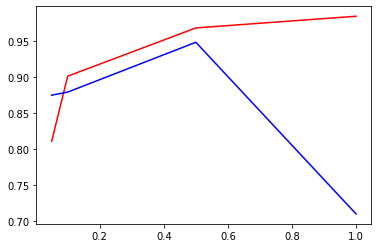

In [0]:
from matplotlib import pyplot as plt
plt.plot([0.05, 0.1, 0.5, 1.0], accuracy_rnn, 'r-', label='RNN')
plt.plot([0.05, 0.1, 0.5, 1.0], accuracy_hmm, 'b-', label='HMM')
plt.show()


**HMM:**

Pros:
* Training is efficient (counting)
* Can get decent performance with small amount of data as shown in the above experiments.
* Interpretable

Cons:
* Worse performance compared to end-to-end neural approaches

**RNN:**

Pros:
* Better performance than HMM with enough data and enough model capacity as shown in the above experiments.

Cons:
* Not interpretable
* Needs huge training set
* Training is not as efficient